In [1]:
import sys
sys.path.append("..") 

In [25]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import os
import torch.cuda
import albumentations as albu
import segmentation_models_pytorch as smp
from  segmentation_models_pytorch.utils.base import Metric
from segmentation_models_pytorch.base.modules import Activation
from collections import defaultdict
from torchvision import transforms, utils
from torch.utils.tensorboard import SummaryWriter
import torchvision

In [3]:
from Utils.dataset_utils import *
from Utils.visualization_utils import *

In [4]:
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [5]:
DATASET_2D_BASE_PATH=Path('G:\Projects and Work\Mouse Heart Segmentation\Mice_CT_Dataset\Axials')
WIDTH=320
HEIGHT=320

In [6]:


def get_training_augmentation():
    train_transform = [
        albu.Resize(HEIGHT, WIDTH),
        albu.ShiftScaleRotate(scale_limit=0.20, rotate_limit=30, shift_limit=0.1, p=1, border_mode=cv2.BORDER_CONSTANT),
        albu.RandomCrop(height=320, width=320),
        albu.Blur(blur_limit=3, p=0.4),
        albu.GaussNoise(p=0.5),
        albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        albu.RandomBrightness(p=0.75)

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        albu.Resize(512, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [107]:
df_train=load_data(DATASET_2D_BASE_PATH/'train')[0:24]
df_val=load_data(DATASET_2D_BASE_PATH/'val')[0:24]
df_train.head()

,images,masks
0,G:\Projects and Work\Mouse Heart Segmentation\...,G:\Projects and Work\Mouse Heart Segmentation\...
1,G:\Projects and Work\Mouse Heart Segmentation\...,G:\Projects and Work\Mouse Heart Segmentation\...
2,G:\Projects and Work\Mouse Heart Segmentation\...,G:\Projects and Work\Mouse Heart Segmentation\...
3,G:\Projects and Work\Mouse Heart Segmentation\...,G:\Projects and Work\Mouse Heart Segmentation\...
4,G:\Projects and Work\Mouse Heart Segmentation\...,G:\Projects and Work\Mouse Heart Segmentation\...


### Visualization of Augmentations

(16, 320, 320, 3)


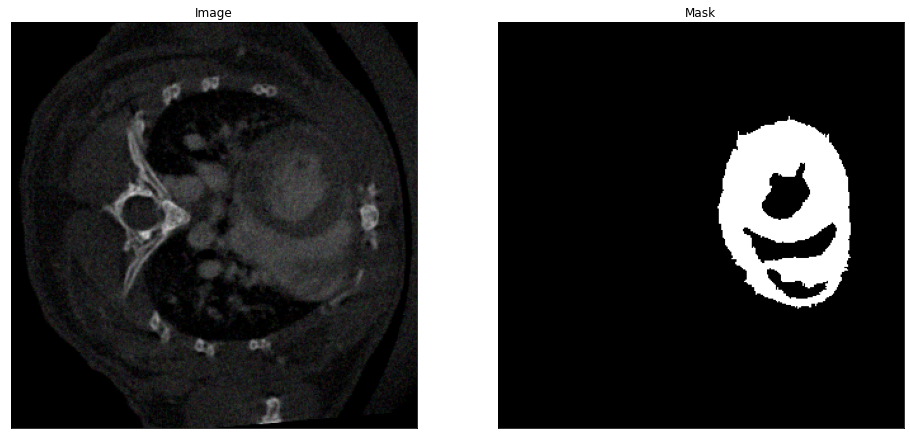

In [106]:
vis_dataset = Dataset(
    df_train['images'], 
    df_train['masks'], 
    augmentation=get_training_augmentation(), 
    )

vis_loader = DataLoader(vis_dataset, batch_size=16, shuffle=True, num_workers=0)
images_batch,masks_batch=next(iter(vis_loader))
print(images_batch.numpy().shape)
idx=np.random.randint(16)


visualize(image=images_batch[idx],mask=masks_batch[idx])


### Training

In [114]:
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'
TRAIN_RUNS_PATH=r'G:\Projects and Work\Mouse Heart Segmentation\runs'
MODEL_NAME='Unet'
BATCH_SIZE=2
EPOCHS=4


In [115]:
HUMAN_WEIGHTS_PATH=r'G:\Projects and Work\Mouse Heart Segmentation\Trained Weights - Human Heart\imagenet'

In [116]:
ENCODERS = ['se_resnext50_32x4d','resnet101','efficientnet-b4']

In [ ]:
for k in [False,True ]:
    is_human_heart_transfer=k
    for j in range(len(ENCODERS)):
        if is_human_heart_transfer:
            model=torch.load(os.path.join(HUMAN_WEIGHTS_PATH,f'Unet_{ENCODERS[j]}','best.pt'))
        else:
            model = smp.Unet(
            encoder_name=ENCODERS[j], 
            encoder_weights=ENCODER_WEIGHTS, 
            classes=1, 
            activation=ACTIVATION,
            )


        preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODERS[j], ENCODER_WEIGHTS)
        WEIGHTS_PATH=os.path.join(TRAIN_RUNS_PATH,f'{MODEL_NAME}_{ENCODERS[j]}')
        if is_human_heart_transfer:
            WEIGHTS_PATH=WEIGHTS_PATH+'_WHS_Fine_Tuned'

        if os.path.exists(WEIGHTS_PATH)==False:
            os.mkdir(WEIGHTS_PATH)
        else:
            print(f"Warning! Directory {WEIGHTS_PATH } already exists")

        train_dataset = Dataset(
        df_train['images'], 
        df_train['masks'], 
        augmentation=get_training_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn)
        )

        valid_dataset = Dataset(
            df_val['images'], 
            df_val['masks'], 
            augmentation=get_validation_augmentation(), 
            preprocessing=get_preprocessing(preprocessing_fn)
        ) 

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        loss = smp.utils.losses.DiceLoss()
        metrics = [
            smp.utils.metrics.IoU(threshold=0.5),
            smp.utils.metrics.Fscore()

        ]

        optimizer = torch.optim.Adam([ 
            dict(params=model.parameters(), lr=0.0001),
        ])
        train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
        )

        valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
        )
        min_loss = 100000000
        train_history=defaultdict(list)
        valid_history=defaultdict(list)
        if is_human_heart_transfer:
            comment = f'model = {ENCODERS[j]}_WHS_Fine_Tuned'
        else:
            comment = f'model = {ENCODERS[j]}_imagenet'

        tb = SummaryWriter(comment)
    #     images, labels = next(iter(train_loader))
    #     grid = torchvision.utils.make_grid(images)
    #     images=images.to(DEVICE)
    #     tb.add_image("images", grid)
    #     tb.add_graph(model, images)
    #     tb.close()
        for i in range(0, EPOCHS):

            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader)
            valid_logs = valid_epoch.run(valid_loader)

            # do something (save model, change lr, etc.)
            if min_loss > valid_logs['dice_loss']:
                min_loss = valid_logs['dice_loss']
                torch.save(model, os.path.join(WEIGHTS_PATH,f'best_{str(i)}_{round(min_loss,4)}.pt'))
                print('Model saved!')

            if i == 25:
                optimizer.param_groups[0]['lr'] = 1e-5
                print('Decrease decoder learning rate to 1e-5!')
            # Maintain History
            for log_key in train_logs.keys():
                train_history[log_key].append(train_logs[log_key])
                valid_history[log_key].append(valid_logs[log_key])
                tb.add_scalar(f'train_{log_key}',train_logs[log_key], i)
                tb.add_scalar(f'validation_{log_key}',valid_logs[log_key], i)

    #     tb.add_hparams(
    #         {"model": ENCODERS[j]},{"min_loss": min_loss}
    #     )
        torch.save(model, os.path.join(WEIGHTS_PATH,f'best.pt'))

        del model

        pd.DataFrame(valid_history).to_csv(os.path.join(WEIGHTS_PATH,'validation_logs.csv'))
        pd.DataFrame(train_history).to_csv(os.path.join(WEIGHTS_PATH,'train_logs.csv'))
        print(f"{WEIGHTS_PATH} Completed!!!")
tb.close()


Epoch: 0
valid: 100%|███████████████| 12/12 [00:01<00:00,  8.35it/s, dice_loss - 1.0, iou_score - 2.289e-13, fscore - 2.289e-13]
Model saved!

Epoch: 1
valid: 100%|███████████████| 12/12 [00:01<00:00,  8.23it/s, dice_loss - 1.0, iou_score - 3.121e-13, fscore - 3.121e-13]
Model saved!

Epoch: 2
valid: 100%|███████████████| 12/12 [00:01<00:00,  8.20it/s, dice_loss - 1.0, iou_score - 4.785e-13, fscore - 4.785e-13]
Model saved!

Epoch: 3
valid: 100%|███████████████| 12/12 [00:01<00:00,  8.40it/s, dice_loss - 1.0, iou_score - 7.148e-13, fscore - 7.148e-13]
Model saved!
G:\Projects and Work\Mouse Heart Segmentation\runs\Unet_se_resnext50_32x4d Completed!!!

Epoch: 0
valid: 100%|███████████████| 12/12 [00:01<00:00,  8.25it/s, dice_loss - 1.0, iou_score - 5.632e-13, fscore - 5.632e-13]
Model saved!

Epoch: 1
valid: 100%|███████████████| 12/12 [00:01<00:00,  8.21it/s, dice_loss - 1.0, iou_score - 1.105e-12, fscore - 1.105e-12]
Model saved!

Epoch: 2
valid: 100%|███████████████| 12/12 [00:01<00

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to C:\Users\Shaheryar/.cache\torch\hub\checkpoints\efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]